In [1]:
%run utilities.ipynb 
load_standard_packages()
change_wordir()
from matplotlib.lines import Line2D
import itertools as it
from tqdm import tqdm
import logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

Could not find cannot import name 'dopri5' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'rodas' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'odassl' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase\lib\site-packages\assimulo\lib\__init__.py)
Could not find ODEPACK functions.
Could not find RADAR5
Could not find GLIMDA.


1.58.0


In [2]:
analysis = "steady_state_dynamics"

colors, colours = colourblind_palette("own")

#model = "cyclic_2021" # saadat cyclic electron flow 2021
model = "cyclic_2021_ODE"
#model = "new_PSI"
#model = "new_PSII"
#model = "new_b6f"
#model = "latest_dev"

m = load_model(model)


succesfully loaded cyclic_2021_ODE :D


In [3]:
y0 = get_stst_y0(m)

In [4]:
# update parameters if wanted
#m.update_parameter("pKreg",  6.0)

# generating data

In [5]:
def pfd_ss_scan(s: object, pfd_values: np.ndarray, y0_loop: dict, debug: bool =False) -> tuple:
    """
    Perform a steady-state scan by varying the parameter "pfd" across different values.

    Returns:
    tuple:
        - DataFrame of steady-state concentrations (rows: pfd values, columns: compound names).
        - DataFrame of steady-state fluxes (rows: pfd values, columns: reaction rates).
    """

    backup_y0 = y0_loop.copy()  # Backup the conditions to reset the system if needed

    fluxes = {}  # store steady-state fluxes for each pfd value
    concentrations = {}  # store steady-state concentrations for each pfd value
    failed_cases = []

    # Iterate over each pfd value with a progress bar
    for x in tqdm(pfd_values, total=len(pfd_values)):  

        s.initialise(y0_loop)  # Reset the system with the given initial conditions
        s.update_parameter("pfd", x)  # Update the parameter "pfd" to the current value
        
        try:
            t, y = s.simulate_to_steady_state()

            if y is None or len(y) == 0:  # Check for invalid output
                raise ValueError(f"Simulation returned empty result at pfd={x}")

            # Store the final steady-state concentrations
            concentrations[x] = s.get_full_results_array()[-1]

            # Store the final steady-state fluxes
            fluxes[x] = s.model.get_fluxes_array(y=y, t=t)[-1]

            # Update initial conditions for the next iteration
            y0_loop = s.get_new_y0()

        except Exception as e:
            logger.warning(f"Simulation failed at pfd={x}: {e}")
            failed_cases.append(x)

            # Store NaNs for failed cases
            all_compounds = s.model.get_all_compounds()
            rate_names = s.model.get_rate_names()
            concentrations[x] = np.full(len(all_compounds), np.nan)
            fluxes[x] = np.full(len(rate_names), np.nan)

            # If debug mode is enabled, log additional details
            if debug:
                logger.debug(f"Failed pfd={x}. Initial conditions: {y0_loop}")

    # Log summary after execution
    logger.info(f"Simulation completed. {len(failed_cases)} cases failed: {failed_cases}")

    return (
        pd.DataFrame(concentrations, index=s.model.get_all_compounds()).T,  # Convert concentration results to DataFrame
        pd.DataFrame(fluxes, index=s.model.get_rate_names()).T  # Convert flux results to DataFrame
    )

NUM_SCANS = 100
LOW_LIGHT = 30
HIGH_LIGHT = 1750
PFD_VALUES = np.linspace(LOW_LIGHT, HIGH_LIGHT, NUM_SCANS)

In [6]:
s = Simulator(m)
c, v = pfd_ss_scan(s, PFD_VALUES, y0, True)

100%|██████████| 100/100 [00:58<00:00,  1.70it/s]
2025-05-27 13:56:10,307 - INFO - Simulation completed. 0 cases failed: []


In [7]:
# c = checkpoint("c", f"{model}/{analysis}", "c", overwrite=True) #this comment is here to recover original code quickly once changed
# v = checkpoint("v", f"{model}/{analysis}", "v", overwrite=True)

c = checkpoint("c", f"{model}/{analysis}", "c", overwrite=True) 
v = checkpoint("v", f"{model}/{analysis}", "v", overwrite=True)

Overwritten: data/cyclic_2021_ODE/steady_state_dynamics\c.joblib,  (backup created at data/cyclic_2021_ODE/steady_state_dynamics\backup_c.joblib)
Overwritten: data/cyclic_2021_ODE/steady_state_dynamics\v.joblib,  (backup created at data/cyclic_2021_ODE/steady_state_dynamics\backup_v.joblib)


In [15]:
# del c

# plotting

### compounds

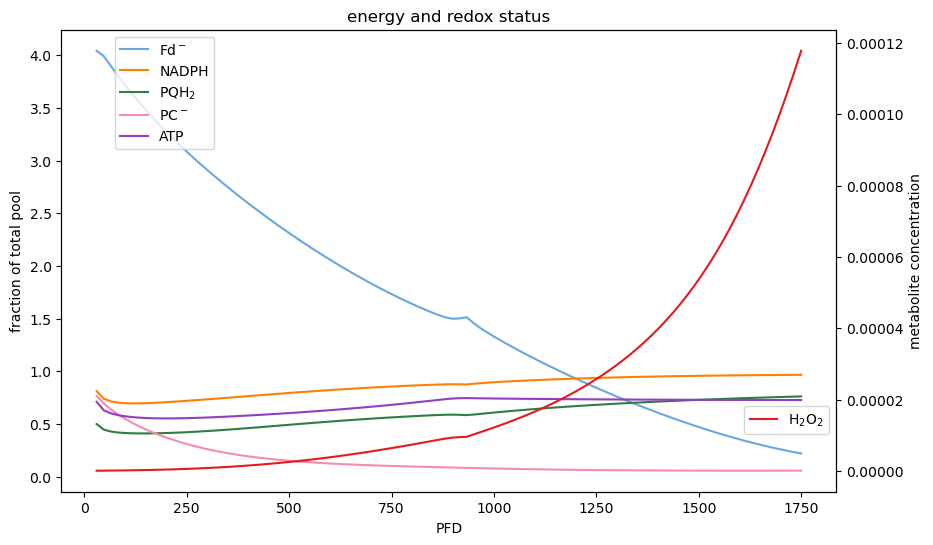

In [ ]:
# ELECTRON CARRIERS

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
ax2 = ax1.twinx()

ax1.plot(c["Fd_redoxstate"], label="Fd$^-$", color=colors[0])
ax1.plot(c["NADP_redoxstate"], label="NADPH", color=colors[1])
ax1.plot(c["PQ_redoxstate"], label="PQH$_2$", color=colors[2])
ax1.plot(c["PC_redoxstate"], label="PC$^-$", color=colors[3])
ax1.plot(c["ATP_norm"], label="ATP", color=colors[4])

ax2.plot(c["H2O2"], label="H$_2$O$_2$", color=colors[5])

# Set labels and legends
ax1.set(title="energy and redox status",
        xlabel="PFD",
        ylabel="fraction of total pool")
ax2.set_ylabel("metabolite concentration")

# Legends
ax1.legend(loc="upper left", bbox_to_anchor=(0.06, 1))
ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.2))


In [6]:
save_fig(fig, model, analysis, f"energy_and_redox_status")

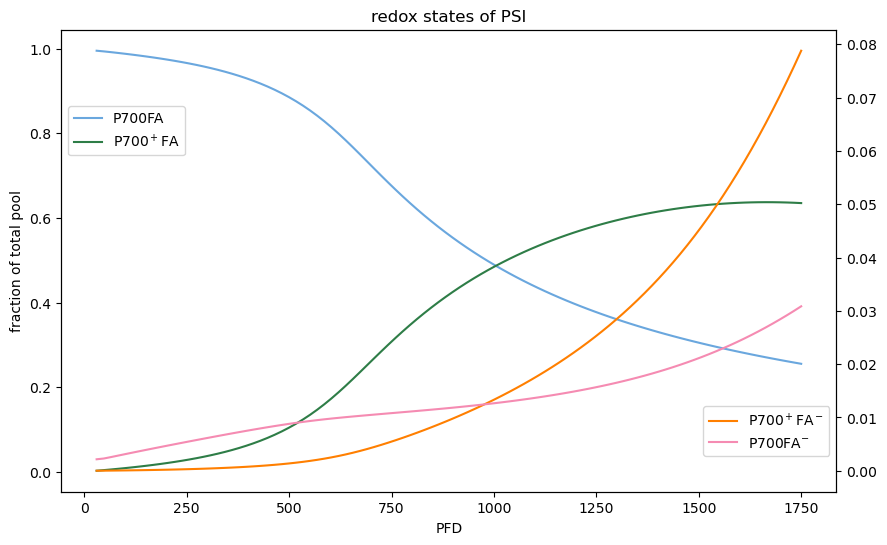

In [8]:
# PSI REDOX STATES

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
ax2 = ax1.twinx()

ax1.plot(c["rel_P700FA"], label="P700FA", color=colors[0])
ax2.plot(c["rel_P700+FA-"], label="P700$^+$FA$^-$", color=colors[1])
ax1.plot(c["rel_P700+FA"], label="P700$^+$FA", color =colors[2])

if model != "cyclic_2021":
        ax2.plot(c["rel_P700FA-"], label = "P700FA$^{-}$", color=colors[3])

# Set labels and legends
ax1.set(title="redox states of PSI",
        xlabel="PFD",
        ylabel="fraction of total pool")

# Legends
ax1.legend(loc="upper left", bbox_to_anchor=(0, 0.85))
ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.2))


In [8]:
save_fig(fig, model, analysis, f"PSI_redox_states")

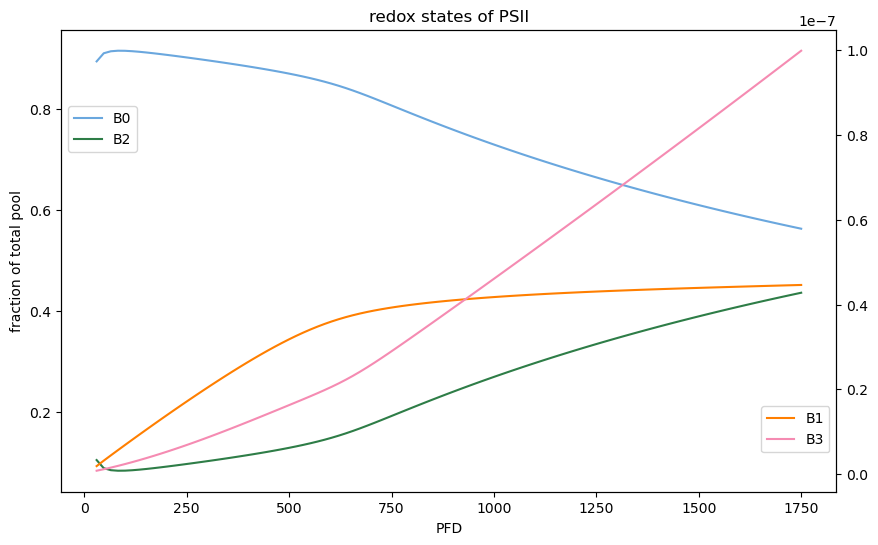

In [9]:
# PSII REDOX STATES

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
ax2 = ax1.twinx()

ax1.plot(c["rel_B0"], label="B0", color=colors[0])
ax2.plot(c["rel_B1"], label="B1", color=colors[1])
ax1.plot(c["rel_B2"], label="B2", color =colors[2])
ax2.plot(c["rel_B3"], label="B3", color=colors[3])

# Set labels and legends
ax1.set(title="redox states of PSII",
        xlabel="PFD",
        ylabel="fraction of total pool")

# Legends
ax1.legend(loc="upper left", bbox_to_anchor=(0, 0.85))
ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.2))

### fluxes

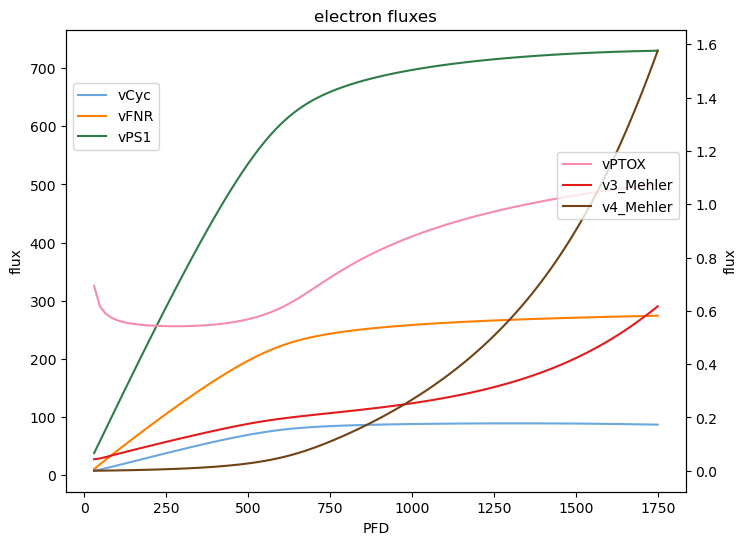

In [10]:
# ELECTRON FLUXES

fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()
#ax3 = ax1.twinx()

ax1.plot(v["vCyc"], label="vCyc", color=colors[0])
ax1.plot(v["vFNR"], label="vFNR", color=colors[1])
ax1.plot(v["vPS1"], label="vPS1", color=colors[2])

ax2.plot(v["vPTOX"], label="vPTOX", color=colors[3])
if model != "cyclic_2021":
        ax2.plot(v["v3_Mehler"], label="v3_Mehler", color=colors[5])
        ax2.plot(v["v4_Mehler"], label="v4_Mehler", color=colors[6])
else:
        ax2.plot(v["vMehler"], label="vMehler", color=colors[4])  # ! if model is old

#ax3.plot(c["pH"], label="pH", color=colors[7])

ax1.set(title="electron fluxes",
        xlabel="PFD",
        ylabel="flux")
ax2.set_ylabel("flux")
#ax3.set_ylabel("pH")

ax1.legend(loc='upper left', bbox_to_anchor=(0, 0.9))
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.75))
#ax3.legend(loc='upper right', bbox_to_anchor=(1, 0.11))

fig.show()


In [13]:
save_fig(fig, model, analysis, f"electron_flows")

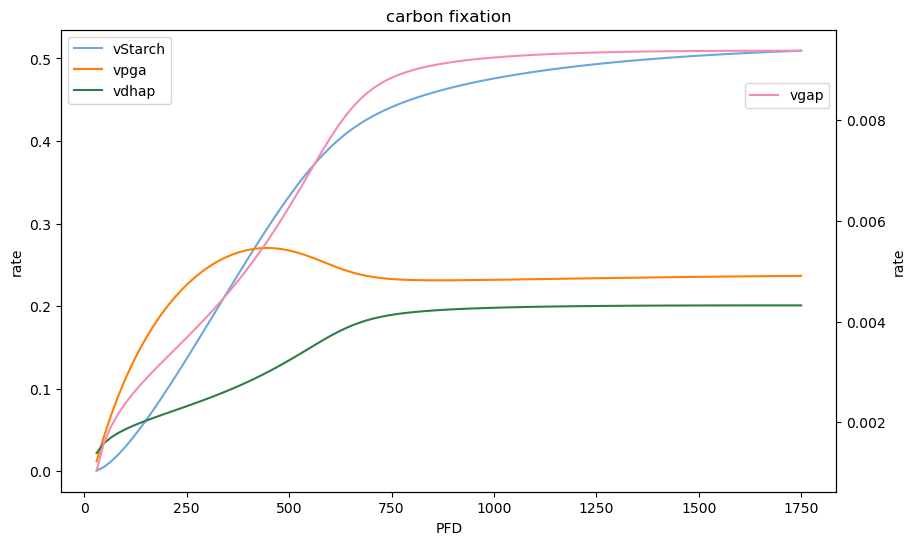

In [11]:
# CARBON FIXATION

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

ax1.plot(v["vStarch"], label="vStarch", color=colors[0])
ax1.plot(v["vpga"], label="vpga", color=colors[1])
ax1.plot(v["vdhap"], label="vdhap", color=colors[2])

ax2.plot(v["vgap"], label="vgap", color=colors[3])

ax1.set(title="carbon fixation",
        xlabel="PFD",
        ylabel="rate")
ax2.set_ylabel("rate")

ax1.legend(loc='upper left', bbox_to_anchor=(0, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9))

fig.show()

In [15]:
save_fig(fig, model, analysis, f"carbon_fixation_fluxes")

# ATP-ase

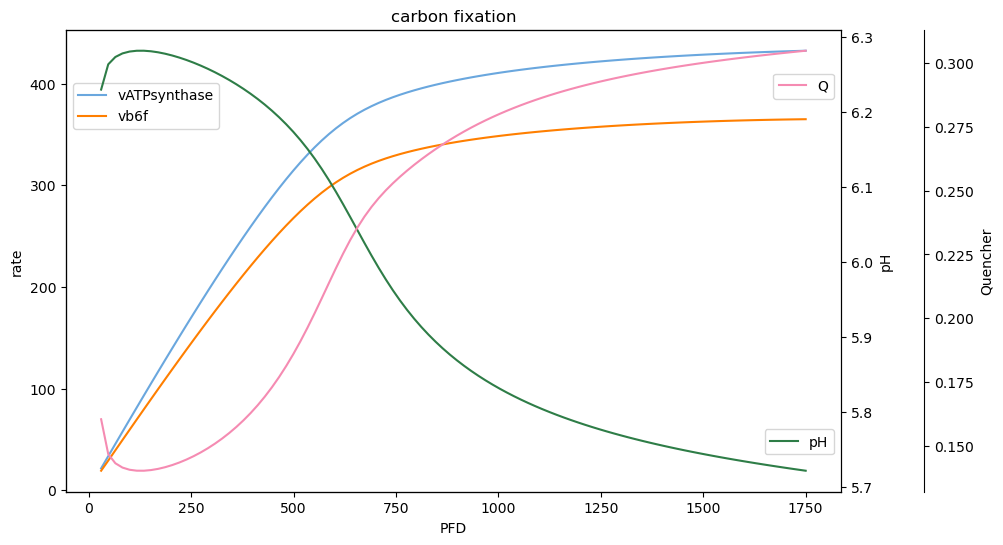

In [12]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis

ax1.plot(v["vATPsynthase"], label="vATPsynthase", color=colors[0])
ax1.plot(v["vB6f"], label="vb6f", color=colors[1])

ax2.plot(c["pH"], label="pH", color=colors[2])

ax3.plot(c["Q"], label="Q", color=colors[3])


ax1.set(title="carbon fixation",
        xlabel="PFD",
        ylabel="rate")
ax2.set_ylabel("pH")
ax3.set_ylabel("Quencher")

ax1.legend(loc='upper left', bbox_to_anchor=(0, 0.9))
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.15))
ax3.legend(loc='upper right', bbox_to_anchor=(1, 0.92))

fig.show()

In [17]:
save_fig(fig, model, analysis, f"ph_responsive_effects")

# compare different models

In [8]:
c_orig = checkpoint(".", f"cyclic_2021/{analysis}", filename="c")
v_orig = checkpoint(".", f"cyclic_2021/{analysis}", filename="v")

c_orig_ODE = checkpoint(".", f"cyclic_2021_ODE/{analysis}", filename="c")
v_orig_ODE = checkpoint(".", f"cyclic_2021_ODE/{analysis}", filename="v")

c_PSI = checkpoint(".", f"new_PSI/{analysis}", filename="c")
v_PSI = checkpoint(".", f"new_PSI/{analysis}", filename="v")

c_new_PSs = checkpoint(".", f"new_PSII/{analysis}", filename="c")
v_new_PSs = checkpoint(".", f"new_PSII/{analysis}", filename="v")

c_new_b6f = checkpoint(".", f"new_b6f/{analysis}", filename="c")
v_new_b6f = checkpoint(".", f"new_b6f/{analysis}", filename="v")

c_latest = checkpoint(".", f"latest_dev/{analysis}", filename="c")
v_latest = checkpoint(".", f"latest_dev/{analysis}", filename="v")

# c_latest_60 = checkpoint("c_latest_60", f"latest_dev/{analysis}", filename="c_60")
# v_latest_60 = checkpoint("v_latest_60", f"latest_dev/{analysis}", filename="v_60")

Loaded: data/cyclic_2021/steady_state_dynamics\c.joblib
Loaded: data/cyclic_2021/steady_state_dynamics\v.joblib
Loaded: data/cyclic_2021_ODE/steady_state_dynamics\c.joblib
Loaded: data/cyclic_2021_ODE/steady_state_dynamics\v.joblib
Loaded: data/new_PSI/steady_state_dynamics\c.joblib
Loaded: data/new_PSI/steady_state_dynamics\v.joblib
Loaded: data/new_PSII/steady_state_dynamics\c.joblib
Loaded: data/new_PSII/steady_state_dynamics\v.joblib
Loaded: data/new_b6f/steady_state_dynamics\c.joblib
Loaded: data/new_b6f/steady_state_dynamics\v.joblib
Loaded: data/latest_dev/steady_state_dynamics\c.joblib
Loaded: data/latest_dev/steady_state_dynamics\v.joblib


In [8]:
#del var_name

In [14]:
# data_var_name: ["linestyle", linewidth]
models = {
        "orig": [":", 1],
        #"orig_ODE": [":", 2],
        # "PSI": ["--", 1],
        #"new_PSs": [":", 2],
        "latest": ["-", 1],
        #"new_b6f": ["-", 1]
        }

# [((0, (0.5, 2))), 2], [((0, (1, 2))), 2],

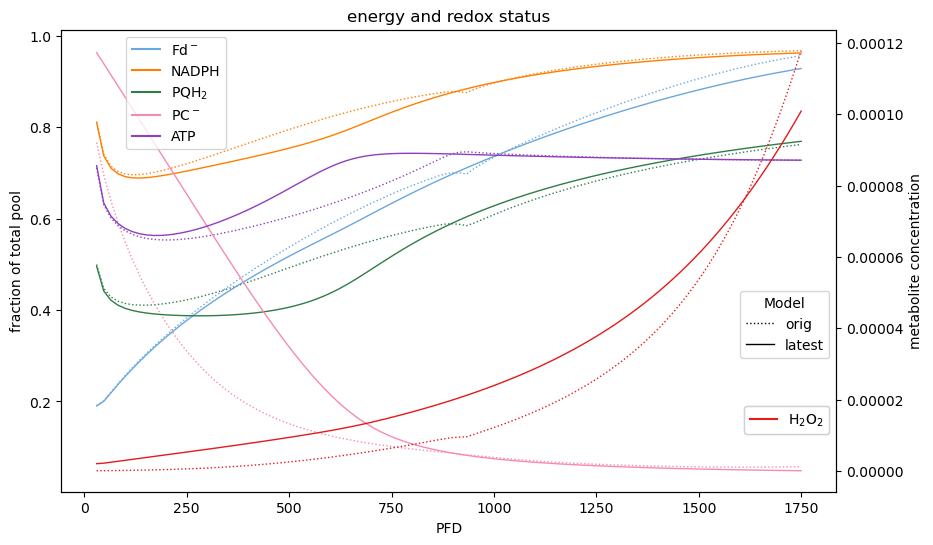

In [15]:
# ELECTRON CARRIERS

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
ax2 = ax1.twinx()

model_handles = []

for model_name, (style, width) in models.items():
        c_model = locals()[f"c_{model_name}"]  # Use locals() to access the variable by name
        ax1.plot(c_model["Fd_redoxstate"], label="Fd$^-$", color=colors[0], linestyle=style, linewidth=width)
        ax1.plot(c_model["NADP_redoxstate"], label="NADPH", color=colors[1], linestyle=style, linewidth=width)
        ax1.plot(c_model["PQ_redoxstate"], label="PQH$_2$", color=colors[2], linestyle=style, linewidth=width)
        ax1.plot(c_model["PC_redoxstate"], label="PC$^-$", color=colors[3], linestyle=style, linewidth=width)
        ax1.plot(c_model["ATP_norm"], label="ATP", color=colors[4], linestyle=style, linewidth=width)

        ax2.plot(c_model["H2O2"], label="H$_2$O$_2$", color=colors[5], linestyle=style, linewidth=width)

        model_handles.append(Line2D([0], [0], color='black', linestyle=style, lw=width, label=model_name))

# Set labels and legends
ax1.set(title="energy and redox status",
        xlabel="PFD",
        ylabel="fraction of total pool")
ax2.set_ylabel("metabolite concentration")

# Legends

metabolite_handles1 = [
        Line2D([0], [0], label="Fd$^-$", color=colors[0]),
        Line2D([0], [0], label="NADPH", color=colors[1]),
        Line2D([0], [0], label="PQH$_2$", color=colors[2]),
        Line2D([0], [0], label="PC$^-$", color=colors[3]),
        Line2D([0], [0], label="ATP", color=colors[4])
]
metabolite_handles2 = [
        Line2D([0], [0], label="H$_2$O$_2$", color=colors[5])
]

legend1 = ax1.legend(handles=metabolite_handles1, loc="upper left",  bbox_to_anchor=(0.075, 1))
legend2 = ax2.legend(handles=metabolite_handles2, loc="upper right", bbox_to_anchor=(1, 0.2))
legend3 = ax1.legend(handles=model_handles,       title="Model")
ax1.add_artist(legend1)
ax2.add_artist(legend2)
ax1.legend(handles=model_handles, title="Model", loc="upper right", bbox_to_anchor=(1, 0.45))

# ax1.legend(loc="upper left", bbox_to_anchor=(0.06, 1))
# ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.2))

In [5]:
save_fig(fig, "multiple_models", analysis, f"electron_and_redox_status")

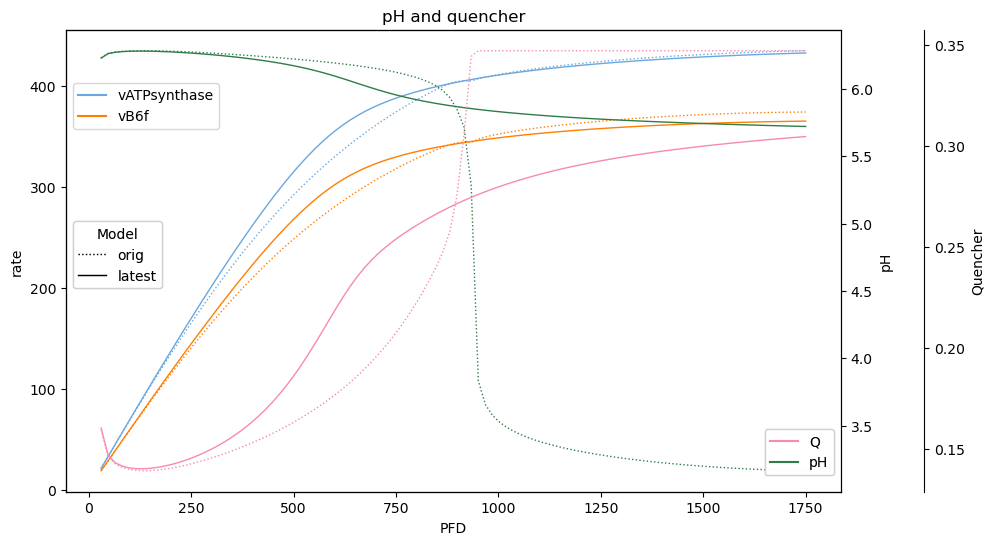

In [16]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis

model_handles = []

for model_name, (style, width) in models.items():
        c_model = locals()[f"c_{model_name}"]  # Use locals() to access the variable by name
        v_model = locals()[f"v_{model_name}"]  # Use locals() to access the variable by name

        ax1.plot(v_model["vATPsynthase"], label="vATPsynthase", color=colors[0], linestyle=style, lw=width)
        ax1.plot(v_model["vB6f"], label="vb6f", color=colors[1], linestyle=style, lw=width)

        ax2.plot(c_model["pH"], label="pH", color=colors[2], linestyle=style, lw=width)

        ax3.plot(c_model["Q"], label="Q", color=colors[3], linestyle=style, lw=width)

        model_handles.append(Line2D([0], [0], color='black', linestyle=style, lw=width, label=model_name))


metabolite_handles1 = [
        Line2D([0], [0], label="vATPsynthase", color=colors[0]),
        Line2D([0], [0], label="vB6f", color=colors[1])
]
metabolite_handles2 = [
        Line2D([0], [0], label="Q", color=colors[3]),
        Line2D([0], [0], label="pH", color=colors[2]),
]

ax1.set(title="pH and quencher",
        xlabel="PFD",
        ylabel="rate")
ax2.set_ylabel("pH")
ax3.set_ylabel("Quencher")

legend1 = ax1.legend(handles=metabolite_handles1, loc="upper left",  bbox_to_anchor=(0, 0.9))
legend2 = ax2.legend(handles=metabolite_handles2, loc="upper right", bbox_to_anchor=(1, 0.15))
legend4 = ax1.legend(handles=model_handles, title="Model", loc="upper left", bbox_to_anchor=(0, 0.6))
ax1.add_artist(legend1)
ax2.add_artist(legend2)
ax1.add_artist(legend4)

fig.show()

In [7]:
save_fig(fig, "multiple_models", analysis, f"pH_and_quencher")

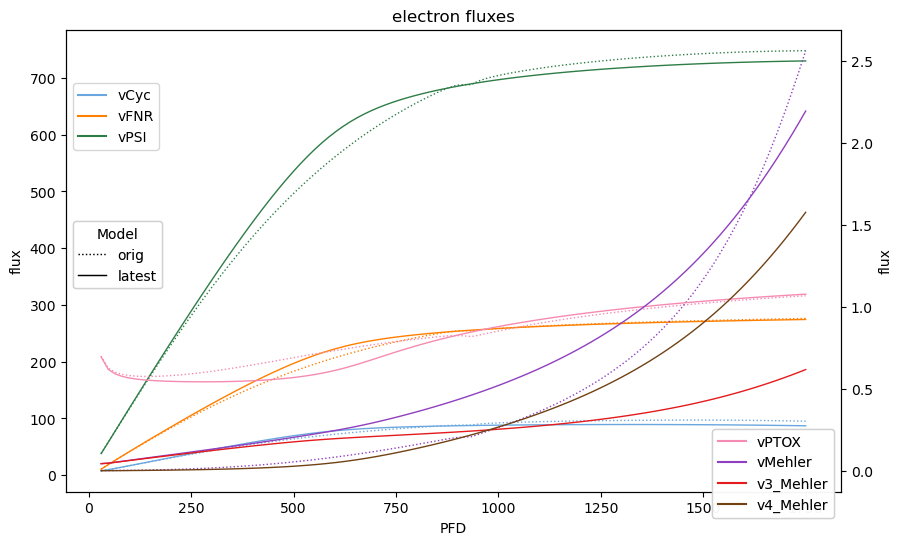

In [17]:
# ELECTRON FLUXES

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

model_handles = []

for model_name, (style, width) in models.items():
        v_model = locals()[f"v_{model_name}"]  # Use locals() to access the variable by name
        ax1.plot(v_model["vCyc"], label="vCyc", color=colors[0], linestyle=style, lw=width)
        ax1.plot(v_model["vFNR"], label="vFNR", color=colors[1], linestyle=style, lw=width)
        ax1.plot(v_model["vPS1"], label="vPS1", color=colors[2], linestyle=style, lw=width)
        # if model_name == "orig":
        #         ax1.plot(v_model["vPS2"]*2, label="vPS2", color=colors[2], linestyle=style, lw=width)
        # else:
        #         ax1.plot(v_model["vB20"], label="vPS2", color=colors[2], linestyle=style, lw=width)

        ax2.plot(v_model["vPTOX"], label="vPTOX", color=colors[3], linestyle=style, lw=width)
        if model_name not in ["orig", "orig_ODE"]:
                ax2.plot(v_model["v3_Mehler"]+v_model["v4_Mehler"], label="vMehler", color=colors[4], linestyle=style, lw=width)
                ax2.plot(v_model["v3_Mehler"], label="v3_Mehler", color=colors[5], linestyle=style, lw=width)
                ax2.plot(v_model["v4_Mehler"], label="v4_Mehler", color=colors[6], linestyle=style, lw=width)
        else:
                ax2.plot(v_model["vMehler"], label="vMehler", color=colors[4], linestyle=style, lw=width)

        model_handles.append(Line2D([0], [0], color='black', linestyle=style, lw=width, label=model_name))

ax1.set(title="electron fluxes",
        xlabel="PFD",
        ylabel="flux")
ax2.set_ylabel("flux")

metabolite_handles1 = [
        Line2D([0], [0], label="vCyc", color=colors[0]),
        Line2D([0], [0], label="vFNR", color=colors[1]),
        Line2D([0], [0], label="vPSI", color=colors[2])
]
metabolite_handles2 = [
        Line2D([0], [0], label="vPTOX", color=colors[3]),
        Line2D([0], [0], label="vMehler", color=colors[4]),
        Line2D([0], [0], label="v3_Mehler", color=colors[5]),
        Line2D([0], [0], label="v4_Mehler", color=colors[6]),
]

legend1 = ax1.legend(handles=metabolite_handles1, loc="upper left",  bbox_to_anchor=(0, 0.9))
legend2 = ax2.legend(handles=metabolite_handles2, loc="upper right", bbox_to_anchor=(1, 0.15))
legend4 = ax1.legend(handles=model_handles, title="Model", loc="upper left", bbox_to_anchor=(0, 0.6))
ax1.add_artist(legend1)
ax2.add_artist(legend2)
ax1.add_artist(legend4)

fig.show()


In [9]:
save_fig(fig, "multiple_models", analysis, f"electron_flows")

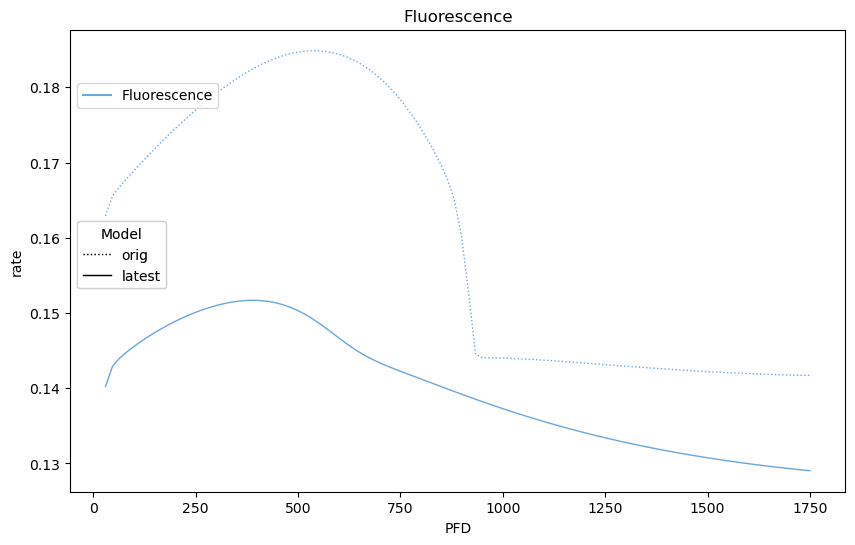

In [18]:
fig, ax1 = plt.subplots(figsize=(10, 6))

model_handles = []

for model_name, (style, width) in models.items():
        c_model = locals()[f"c_{model_name}"]  # Use locals() to access the variable by name

        ax1.plot(c_model["Fluo"], label="Fluorescence", color=colors[0], linestyle=style, lw=width)

        model_handles.append(Line2D([0], [0], color='black', linestyle=style, lw=width, label=model_name))


metabolite_handles1 = [
        Line2D([0], [0], label="Fluorescence", color=colors[0])
        ]

ax1.set(title="Fluorescence",
        xlabel="PFD",
        ylabel="rate")

legend1 = ax1.legend(handles=metabolite_handles1, loc="upper left",  bbox_to_anchor=(0, 0.9))
legend4 = ax1.legend(handles=model_handles, title="Model", loc="upper left", bbox_to_anchor=(0, 0.6))
ax1.add_artist(legend1)
ax1.add_artist(legend4)

fig.show()

In [ ]:
save_fig(fig, "multiple_models", analysis, f"fluorescence")

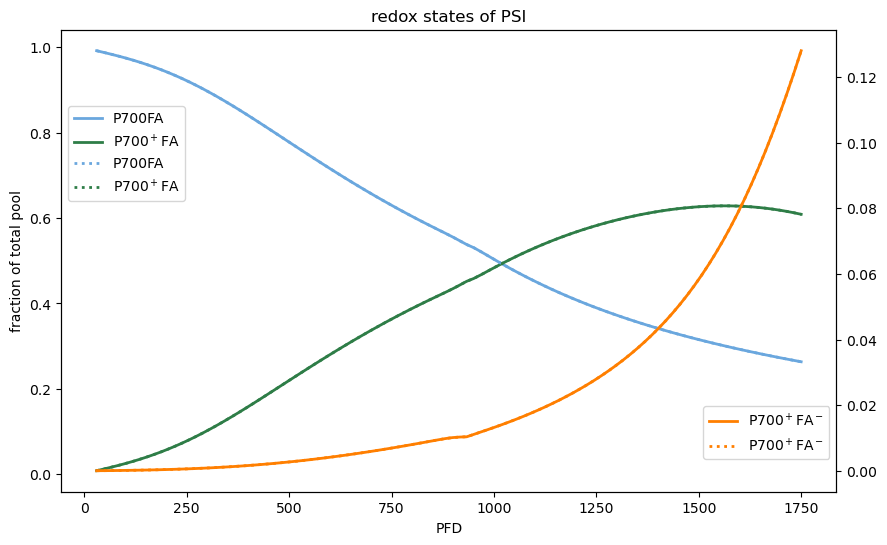

In [16]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

model_handles = []

for model_name, (style, width) in models.items():
        c_model = locals()[f"c_{model_name}"]  # Use locals() to access the variable by name
        ax1.plot(c_model["rel_P700FA"], label="P700FA", color=colors[0], linestyle=style, lw=width)
        ax2.plot(c_model["rel_P700+FA-"], label="P700$^+$FA$^-$", color=colors[1], linestyle=style, lw=width)
        ax1.plot(c_model["rel_P700+FA"], label="P700$^+$FA", color =colors[2], linestyle=style, lw=width)

        if model_name not in ("orig", "orig_ODE", "orig_ODE_v1"):
                ax2.plot(c_model["rel_P700FA-"], label = "P700FA$^{-}$", color=colors[3], linestyle=style, lw=width)
                ax2.plot(c_model["rel_P700+FA-"]+ c_model["rel_P700FA-"], label="FA$^-$", color=colors[4], linestyle=style, lw=width)

# Set labels and legends
ax1.set(title="redox states of PSI",
        xlabel="PFD",
        ylabel="fraction of total pool")

# Legends
ax1.legend(loc="upper left", bbox_to_anchor=(0, 0.85))
ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.2))


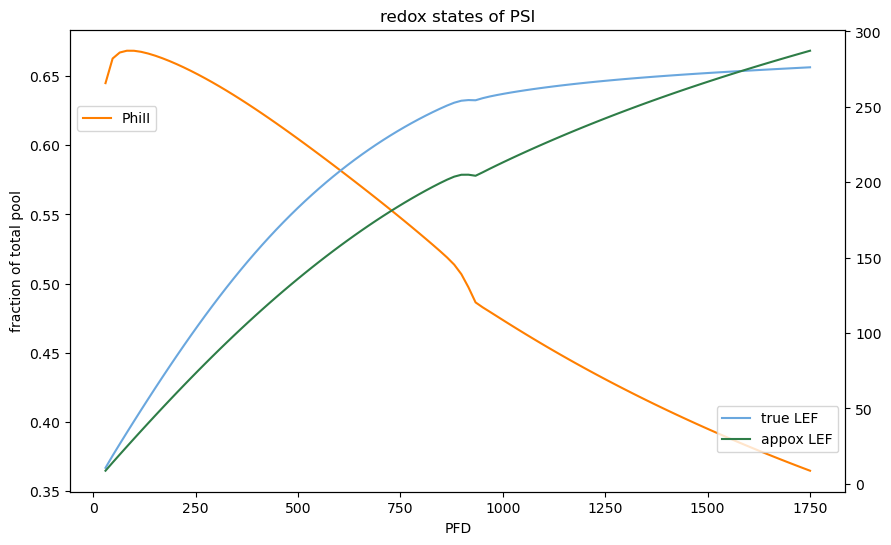

In [17]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

ax2.plot(v["vFNR"], label="true LEF", color=colors[0])

PhiII = v["vB12"] / (v["vB01"] + v["vB23"])
ax1.plot(PhiII, label="PhiII", color=colors[1])

LEF = PhiII * v.index * 0.45 # 0.4?
ax2.plot(LEF, label="appox LEF", color=colors[2])

# Set labels and legends
ax1.set(title="redox states of PSI",
        xlabel="PFD",
        ylabel="fraction of total pool")

# Legends
ax1.legend(loc="upper left", bbox_to_anchor=(0, 0.85))
ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.2))


Photosystem II

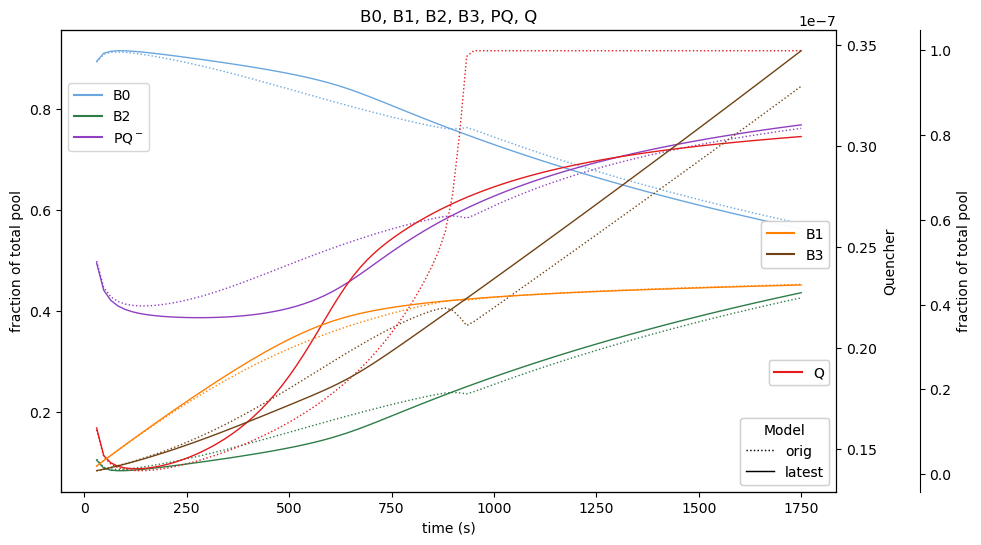

In [39]:
from collections import defaultdict

# Photosystem II

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis
model_handles = []

# Define which metabolites go on which axis
# (key, label, color, axis)
metabolites = [
    ("rel_B0", "B0", colors[0], ax1),
    ("rel_B1", "B1", colors[1], ax3),
    ("rel_B2", "B2", colors[2], ax1),
    ("rel_B3", "B3", colors[6], ax3),
    ("PQ_redoxstate", "PQ$^-$", colors[4], ax1),
    ("Q", "Q", colors[5], ax2),
]

for model_name, (style, width) in models.items():
    c_model = locals()[f"c_{model_name}"]
    for key, label, color, axis in metabolites:
        if key in c_model.columns:
            axis.plot(
                c_model[key],
                label=f"{label} ({model_name})",
                color=color,
                linestyle=style,
                linewidth=width
            )
    model_handles.append(Line2D([0], [0], color='black', linestyle=style, lw=width, label=model_name))

# Set axis labels and title
ax1.set(
    title="B0, B1, B2, B3, PQ, Q",
    xlabel="time (s)",
    ylabel="fraction of total pool",
)
ax2.set_ylabel("Quencher")
ax3.set_ylabel("fraction of total pool")

# Create legend for metabolites, grouped by axis

# Group handles by axis
axis_handles = defaultdict(list)
for key, label, color, axis in metabolites:
    axis_handles[axis].append(Line2D([0], [0], label=label, color=color))

legend1 = ax1.legend(handles=axis_handles[ax1], loc="upper left", bbox_to_anchor=(0, 0.9))
legend2 = ax2.legend(handles=axis_handles[ax2], loc="upper right", bbox_to_anchor=(1, 0.3))
legend3 = ax3.legend(handles=axis_handles[ax3], loc="upper right", bbox_to_anchor=(1, 0.6))
ax1.add_artist(legend1)
ax2.add_artist(legend2)
ax3.add_artist(legend3)

if len(model_handles) > 1:
    model_legend = ax1.legend(handles=model_handles, title="Model", loc="lower right", bbox_to_anchor=(1, 0))
    ax1.add_artist(model_legend)

fig.show()